Using device: cuda
→ Split 'train': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
→ Split 'valid': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
→ Split 'test': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
Saved index for split 'train' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/train_index.json
Saved index for split 'valid' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/valid_index.json
Saved index for split 'test' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/test_index.json


Processing sdf maps: 100%|██████████| 2/2 [00:00<00:00, 192.79it/s]

Loaded 64 tensors from checkpoint.



/tmp/ipykernel_151401/2271703924.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_IN, map_location=device)


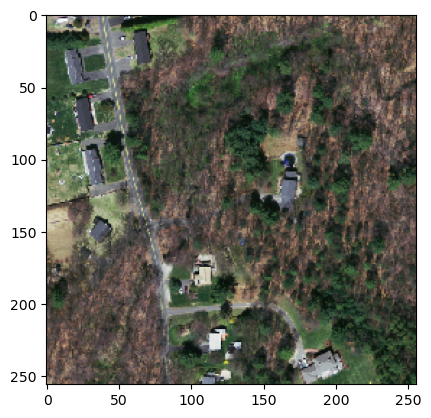

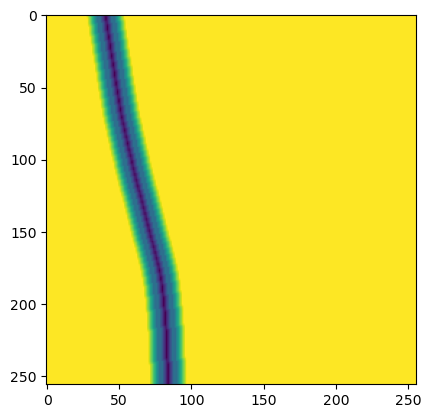

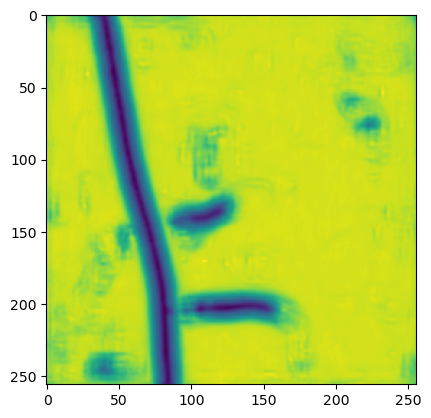

In [1]:
import os
while os.getcwd() !='/home/ri/Desktop/Projects/Codebase':
    os.chdir('../')


import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

from core.general_dataset.base import GeneralizedDataset
from core.general_dataset.collate import worker_init_fn
from core.utils import yaml_read
from models.base_models import UNet
from metrics.apls import APLS
from IPython.display import display
%matplotlib inline

# ─────────────────────────────────────────────────────────────────────────────
# Config paths & hyperparameters
# ─────────────────────────────────────────────────────────────────────────────
DATASET_YAML = "./configs/dataset/mass_test.yaml"
MODEL_YAML   = "./configs/model/baseline.yaml"
CKPT_IN      = "/home/ri/Desktop/Projects/Codebase/AllFayzad/sdf-first-run/epoch002999.ckpt"

NUM_EPOCHS   = 100
LR           = 1e-4
NUM_WORKERS  = 0
CROP_H, CROP_W = 256, 256

# ─────────────────────────────────────────────────────────────────────────────
# Helpers
# ─────────────────────────────────────────────────────────────────────────────
def make_cfg(cfg, split):
    c = cfg.copy()
    c["split"] = split
    if split in ("valid", "test"):
        c["augmentations"] = []
    return c

def center_crop(x: torch.Tensor, crop_h: int, crop_w: int) -> torch.Tensor:
    _, _, H, W = x.shape
    top  = (H - crop_h) // 2
    left = (W - crop_w) // 2
    return x[:, :, top:top+crop_h, left:left+crop_w]

# ─────────────────────────────────────────────────────────────────────────────
# Device
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# Build dataset (valid split → no augmentations)
# ─────────────────────────────────────────────────────────────────────────────
raw_cfg = yaml_read(DATASET_YAML)
fixed_ds = GeneralizedDataset(make_cfg(raw_cfg, "valid"))
smoke_ds = Subset(fixed_ds, indices=[0, 1])
smoke_dl = DataLoader(
    smoke_ds,
    batch_size=2,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    worker_init_fn=worker_init_fn,
)

# ─────────────────────────────────────────────────────────────────────────────
# Model, loss, metric, optimizer
# ─────────────────────────────────────────────────────────────────────────────
model_cfg = yaml_read(MODEL_YAML)["params"]
model     = UNet(**model_cfg).to(device)

if os.path.isfile(CKPT_IN):
    ckpt = torch.load(CKPT_IN, map_location=device)
    state = ckpt.get("state_dict", ckpt)
    state = {k.replace("model.", ""): v for k, v in state.items()}
    state = {k: v for k, v in state.items() if k in model.state_dict()}
    model.load_state_dict(state, strict=False)
    print(f"Loaded {len(state)} tensors from checkpoint.")

apls_fn = APLS(
    data_dim=2, threshold=0, angle_range=(135,225),
    max_nodes=1000, max_snap_dist=4, allow_renaming=True,
    min_path_length=10, greater_is_road=False,
)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

batch = next(iter(smoke_dl))
x = center_crop(batch["image_patch"], CROP_H, CROP_W).to(device, non_blocking=True)
y = center_crop(batch["sdf_patch"],   CROP_H, CROP_W).to(device, non_blocking=True)

pred = model(x)


plt.imshow(x[0].detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(y[0,0].detach().cpu().numpy())
plt.show()
plt.imshow(pred[0,0].detach().cpu().numpy())
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================
# Main Functions with Applied Considerations
# ==============================================================

def sample_pred_at_positions(pred, positions):
    r = positions[:, 0]
    c = positions[:, 1]
    r0 = r.floor().long()
    c0 = c.floor().long()
    r1 = r0 + 1
    c1 = c0 + 1
    dr = (r - r0.float()).unsqueeze(1)
    dc = (c - c0.float()).unsqueeze(1)
    H, W = pred.shape
    r0 = r0.clamp(0, H - 1)
    r1 = r1.clamp(0, H - 1)
    c0 = c0.clamp(0, W - 1)
    c1 = c1.clamp(0, W - 1)
    Ia = pred[r0, c0].unsqueeze(1)
    Ib = pred[r0, c1].unsqueeze(1)
    Ic = pred[r1, c0].unsqueeze(1)
    Id = pred[r1, c1].unsqueeze(1)
    val = (Ia * (1 - dr) * (1 - dc) +
           Ib * (1 - dr) * dc +
           Ic * dr * (1 - dc) +
           Id * dr * dc)
    return val.squeeze(1)

def compute_normals(sdf):
    H, W = sdf.shape
    grad_row = torch.zeros_like(sdf)
    grad_col = torch.zeros_like(sdf)
    # blur = torchvision.transforms.GaussianBlur((3,3), sigma=(1,1))
    # sdf_smoothed = blur(sdf[None])[0]
    sdf_smoothed = sdf
    grad_row[1:-1] = (sdf_smoothed[2:] - sdf_smoothed[:-2]) / 2.0
    grad_col[:, 1:-1] = (sdf_smoothed[:, 2:] - sdf_smoothed[:, :-2]) / 2.0
    grad_row[0]    = sdf_smoothed[1] - sdf_smoothed[0]
    grad_row[-1]   = sdf_smoothed[-1] - sdf_smoothed[-2]
    grad_col[:, 0] = sdf_smoothed[:, 1] - sdf_smoothed[:, 0]
    grad_col[:, -1] = sdf_smoothed[:, -1] - sdf_smoothed[:, -2]
    normals = torch.stack([grad_row, grad_col], dim=2)
    return normals

def sample_normals_at_positions(normals, positions, normalize=True):
    H, W, _ = normals.shape
    r = positions[:, 0]
    c = positions[:, 1]
    r0 = r.floor().long()
    c0 = c.floor().long()
    r1 = r0 + 1
    c1 = c0 + 1
    dr = (r - r0.float()).unsqueeze(1)
    dc = (c - c0.float()).unsqueeze(1)
    r0 = r0.clamp(0, H - 1)
    r1 = r1.clamp(0, H - 1)
    c0 = c0.clamp(0, W - 1)
    c1 = c1.clamp(0, W - 1)
    Ia = normals[r0, c0]
    Ib = normals[r0, c1]
    Ic = normals[r1, c0]
    Id = normals[r1, c1]
    normal_interp = (Ia * (1 - dr) * (1 - dc) +
                     Ib * (1 - dr) * dc +
                     Ic * dr * (1 - dc) +
                     Id * dr * dc)
    
    if normalize:
        norm_val = torch.norm(normal_interp, dim=1, keepdim=True) + 1e-8
        normal_interp = normal_interp / norm_val

    return normal_interp

def extract_zero_crossings_interpolated_positions(sdf_tensor, requires_grad=False):
    """
    Extract zero crossings for a specified direction.
    
    - 'horizontal': Compare vertical neighbors (changes along rows).
    - 'vertical': Compare horizontal neighbors (changes along columns).
    - 'main_diagonal': Compare (i, j) with (i+1, j+1).
    - 'anti_diagonal': Compare (i, j) with (i+1, j-1).
    """
    epsilon = 1e-8
    positions = []
    H, W = sdf_tensor.shape
    sdf_np = sdf_tensor.detach().cpu().numpy()
    
    # Compare vertical neighbors
    for i in range(H - 1):
        for j in range(W):
            v1 = sdf_np[i, j]
            v2 = sdf_np[i + 1, j]
            if v1 == 0:
                positions.append([i, j])
            elif v2 == 0:
                positions.append([i + 1, j])
            elif v1 * v2 < 0:
                # alpha = min(abs(v1), abs(v2)) / (abs(v1) + abs(v2) + epsilon)
                # alpha = abs(v1) / abs(v2)
                alpha = abs(v1) / (abs(v1) + abs(v2) + epsilon)
                row_interp = i + alpha
                positions.append([row_interp, j])
    # Compare horizontal neighbors
    for i in range(H):
        for j in range(W - 1):
            v1 = sdf_np[i, j]
            v2 = sdf_np[i, j + 1]
            if v1 == 0:
                positions.append([i, j])
            elif v2 == 0:
                positions.append([i, j + 1])
            elif v1 * v2 < 0:
                # alpha = min(abs(v1), abs(v2)) / (abs(v1) + abs(v2) + epsilon)
                # alpha = abs(v1) / abs(v2)
                alpha = abs(v1) / (abs(v1) + abs(v2) + epsilon)

                col_interp = j + alpha
                positions.append([i, col_interp])
                    
    if positions:
        return torch.tensor(positions, dtype=torch.float32, device=sdf_tensor.device, requires_grad=requires_grad)
    else:
        return torch.empty((0, 2), dtype=torch.float32, device=sdf_tensor.device, requires_grad=requires_grad)
    
def compute_chamfer_distance(points1, points2):
    if points1.numel() == 0 or points2.numel() == 0:
        return torch.tensor(float('inf'), device=points1.device)
    diff = points1.unsqueeze(1) - points2.unsqueeze(0)
    dists = torch.norm(diff, dim=2)
    min_dists1, _ = torch.min(dists, dim=1)
    min_dists2, _ = torch.min(dists, dim=0)
    return -torch.mean(min_dists1) + torch.mean(min_dists2)


def manual_chamfer_grad(pred_sdf, pred_zc, gt_zc, update_scale=1.0, dist_threshold=3.0):
    """
    Compute a 'manual' gradient for Chamfer-like boundary alignment.
    We ignore any predicted zero crossings that are too far from
    all ground-truth zero crossings, i.e., they are considered spurious.
    
    Args:
        pred_sdf (Tensor): [H, W], the predicted SDF.
        pred_zc  (Tensor): [N, 2], predicted zero-crossing positions (row, col).
        gt_zc    (Tensor): [M, 2], ground-truth zero-crossing positions (row, col).
        update_scale (float): scaling factor for the gradient magnitude.
        dist_threshold (float): maximum distance for a predicted ZC to be considered valid.
    
    Returns:
        dSDF (Tensor): [H, W], the gradient w.r.t. pred_sdf for the Chamfer loss.
    """
    # Initialize gradient buffer
    dSDF = torch.zeros_like(pred_sdf)
    
    # Compute normals on the entire SDF
    normals = compute_normals(pred_sdf)  # shape: [H, W, 2]
    sampled_normals = sample_normals_at_positions(normals, pred_zc)  # shape: [N, 2]
    
    # Move data to CPU for distance computations
    gt_zc_cpu = gt_zc.detach().cpu()
    pred_zc_cpu = pred_zc.detach().cpu()

    # Loop over each predicted zero crossing
    for i in range(pred_zc.shape[0]):
        # p is (row, col)
        p = pred_zc_cpu[i]

        # Find nearest ground-truth crossing
        diff = gt_zc_cpu - p  # shape: [M, 2]
        dist = torch.norm(diff, dim=1)  # [M]
        min_dist, min_index = torch.min(dist, dim=0)

        # If the predicted ZC is too far from every GT ZC, skip it (spurious)
        if min_dist > dist_threshold:
            continue

        # Otherwise, compute the usual chamfer update
        matched_gt = gt_zc_cpu[min_index]
        dl_dp = matched_gt - p  # direction from predicted ZC to GT ZC

        # Project onto local normal at p
        n = sampled_normals[i]
        n_norm = torch.norm(n) + 1e-8
        n = n / n_norm
        dot_val = torch.dot(dl_dp.to(n.device), n) * update_scale

        # Distribute the gradient bilinearly among neighboring pixels
        r, c = p[0].item(), p[1].item()
        r0, c0 = int(np.floor(r)), int(np.floor(c))
        r1, c1 = r0 + 1, c0 + 1
        w_r1 = r - r0
        w_r0 = 1 - w_r1
        w_c1 = c - c0
        w_c0 = 1 - w_c1

        H, W = dSDF.shape
        if 0 <= r0 < H and 0 <= c0 < W:
            dSDF[r0, c0] += dot_val * w_r0 * w_c0
        if 0 <= r0 < H and 0 <= c1 < W:
            dSDF[r0, c1] += dot_val * w_r0 * w_c1
        if 0 <= r1 < H and 0 <= c0 < W:
            dSDF[r1, c0] += dot_val * w_r1 * w_c0
        if 0 <= r1 < H and 0 <= c1 < W:
            dSDF[r1, c1] += dot_val * w_r1 * w_c1

    return dSDF


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


NUM_EPOCHS   = 100
λ_chamfer    = 1.0
λ_sdf        = 1.0
update_scale = 100
dist_threshold = 1.5

# Buffers for plotting over time
epoch_losses       = []
mean_grad_mags     = []

def update_pred_sdf(gt_sdf, pred_sdf, gt_zc, pred_zc, optimizer, iter_num, update_scale=1.0, dist_threshold=3.0):
    """
    Updated function that uses a MeshSDF-like trick with bilinear gradient distribution for the Chamfer term,
    combined with a pixel-wise SDF loss.
    """
    pred_sdf.requires_grad_(True)
    optimizer.zero_grad()

    dSDF_chamfer = manual_chamfer_grad(pred_sdf, pred_zc, gt_zc, update_scale=update_scale, dist_threshold=dist_threshold)
    with torch.no_grad():
        pred_sdf.grad = dSDF_chamfer.clone()

    # pred_zc_long = pred_zc.long()
    # print('pred_zc_long.shape:', pred_zc_long.shape)
    # rows, cols = pred_zc_long[:, 0], pred_zc_long[:, 1]
    # loss_pred = pred_sdf[rows, cols].sum()
    zc_values = sample_pred_at_positions(pred_sdf, pred_zc)
    loss_pred = (zc_values).sum()
    loss_pred.backward(retain_graph=True)
    # loss_pred = torch.abs(zc_values).mean()
    # loss_pred.backward(retain_graph=True)
    # loss_pred = (torch.abs(zc_values)).sum()
    # loss_pred.backward(retain_graph=True)
    # print(f"[Iter {iter_num}] Pixel-Value Loss: {loss_pred.item():.4f}")
    
    normals = compute_normals(pred_sdf)
    sampled_normals = sample_normals_at_positions(normals, pred_zc)
    dl_dx_fake = torch.zeros_like(pred_zc)
    dl_ds_per_point = - torch.sum(sampled_normals * dl_dx_fake, dim=1)
    combined_loss = torch.sum(dl_ds_per_point)
    combined_loss.backward()

    optimizer.step()

    return pred_sdf

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    total_loss = 0.0

    for batch in smoke_dl:
        # 1) Prep data
        x = center_crop(batch["image_patch"], CROP_H, CROP_W).to(device, non_blocking=True)
        y = center_crop(batch["sdf_patch"],   CROP_H, CROP_W).to(device, non_blocking=True)

        # 2) Forward
        pred_sdf_b = model(x).squeeze(1)  # [B,H,W]
        gt_sdf_b   = y.squeeze(1)         # [B,H,W]

        # 3) Compute per-sample losses
        batch_loss = 0.0
        for b in range(pred_sdf_b.size(0)):
            p = pred_sdf_b[b]
            g = gt_sdf_b[b]

            pred_zc = extract_zero_crossings_interpolated_positions(p)
            gt_zc   = extract_zero_crossings_interpolated_positions(g)

            loss_chamfer = torch.abs(compute_chamfer_distance(pred_zc, gt_zc))
            loss_sdf     = F.l1_loss(p, g)

            batch_loss += λ_chamfer * loss_chamfer + λ_sdf * loss_sdf

        batch_loss = batch_loss / pred_sdf_b.size(0)

        # 4) Backprop + step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

    avg_loss = total_loss / len(smoke_dl)
    epoch_losses.append(avg_loss)

    # — compute mean |dSDF| on the first sample for monitoring —
    with torch.no_grad():
        sample_p = pred_sdf_b[0].detach().requires_grad_(True)
        sample_g = gt_sdf_b[0].detach()
        p_zc = extract_zero_crossings_interpolated_positions(sample_p)
        g_zc = extract_zero_crossings_interpolated_positions(sample_g)

        dSDF = manual_chamfer_grad(
            sample_p, p_zc, g_zc,
            update_scale=update_scale,
            dist_threshold=dist_threshold
        )
        mean_grad_mags.append(dSDF.abs().mean().item())

    print(f"[Epoch {epoch:03d}/{NUM_EPOCHS:03d}]  Loss: {avg_loss:.4f}  |dSDF|ₘₑₐₙ: {mean_grad_mags[-1]:.4f}")

    # —––––—–––– VISUALIZE EVERYTHING —––––—––––
    # Convert to CPU/numpy
    sample_img  = x[0].cpu().permute(1,2,0).numpy()
    sample_gt   = sample_g.cpu().numpy()
    sample_pred = sample_p.detach().cpu().numpy()
    p_zc_np     = p_zc.cpu().numpy()
    g_zc_np     = g_zc.cpu().numpy()
    dSDF_map    = dSDF.detach().cpu().numpy()

    # set a symmetric vmin/vmax for the SDF plots
    mx = max(sample_gt.max(), sample_gt.min()*-1,
             sample_pred.max(), sample_pred.min()*-1)
    vmin, vmax = -mx, mx

    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    fig.suptitle(f"Epoch {epoch}", fontsize=16)

    # GT SDF + ZCs
    axs[0,0].imshow(sample_gt, cmap='RdBu', vmin=vmin, vmax=vmax)
    axs[0,0].scatter(g_zc_np[:,1], g_zc_np[:,0], s=8, c='lime')
    axs[0,0].set_title("GT SDF + ZCs")
    axs[0,0].axis('off')

    # Predicted SDF + ZCs
    axs[0,1].imshow(sample_pred, cmap='RdBu', vmin=vmin, vmax=vmax)
    axs[0,1].scatter(p_zc_np[:,1], p_zc_np[:,0], s=8, c='red')
    axs[0,1].set_title("Pred SDF + ZCs")
    axs[0,1].axis('off')

    # Chamfer gradient heatmap
    im = axs[1,0].imshow(dSDF_map, cmap='viridis')
    axs[1,0].set_title("Chamfer ∂Loss/∂SDF")
    axs[1,0].axis('off')
    fig.colorbar(im, ax=axs[1,0], fraction=0.046, pad=0.04)

    # Loss & mean grad‐mag curve
    axs[1,1].plot(range(1, epoch+1), epoch_losses, label="Loss")
    axs[1,1].plot(range(1, epoch+1), mean_grad_mags, label="Mean |dSDF|")
    axs[1,1].set_title("Loss & mean |dSDF| over epochs")
    axs[1,1].set_xlabel("Epoch")
    axs[1,1].legend()
    axs[1,1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


[Epoch 001/100]  Loss: 5.5325


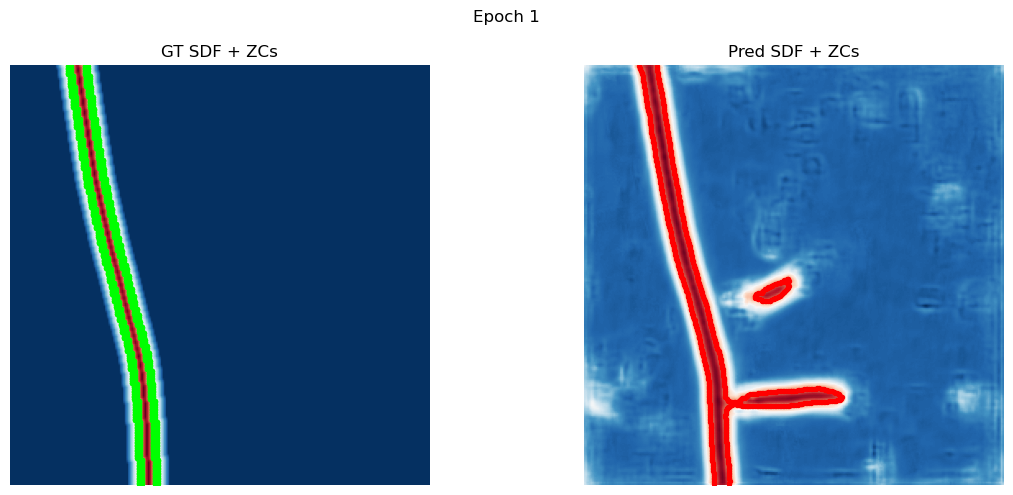

[Epoch 002/100]  Loss: 4.6561


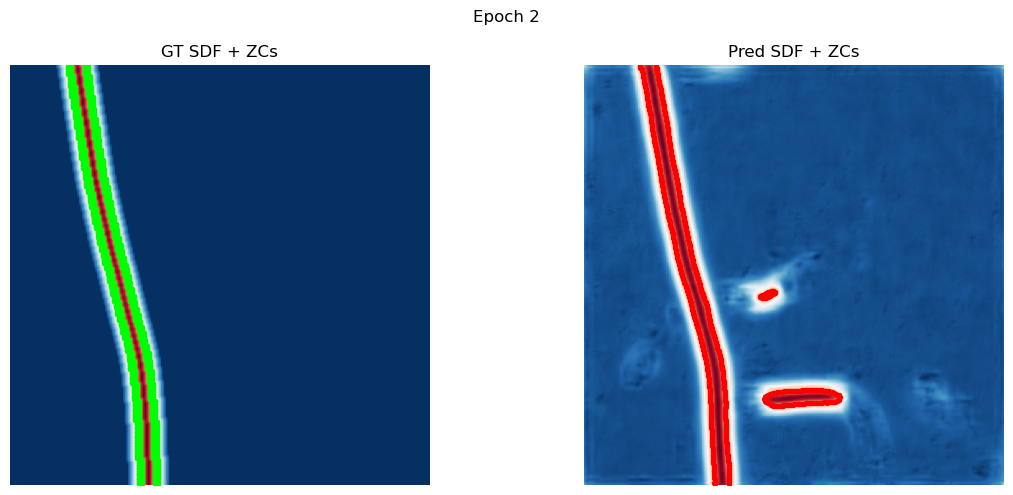

[Epoch 003/100]  Loss: 1.3092


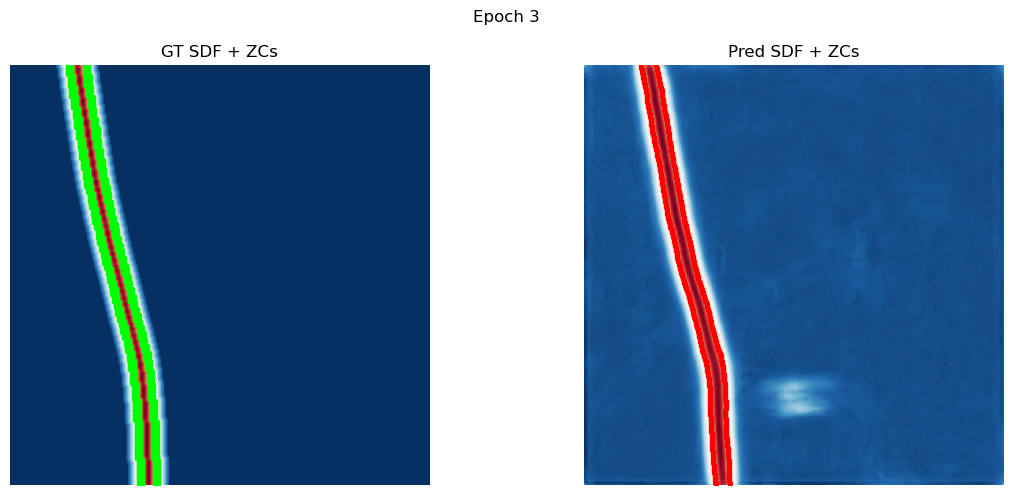

[Epoch 004/100]  Loss: 1.0766


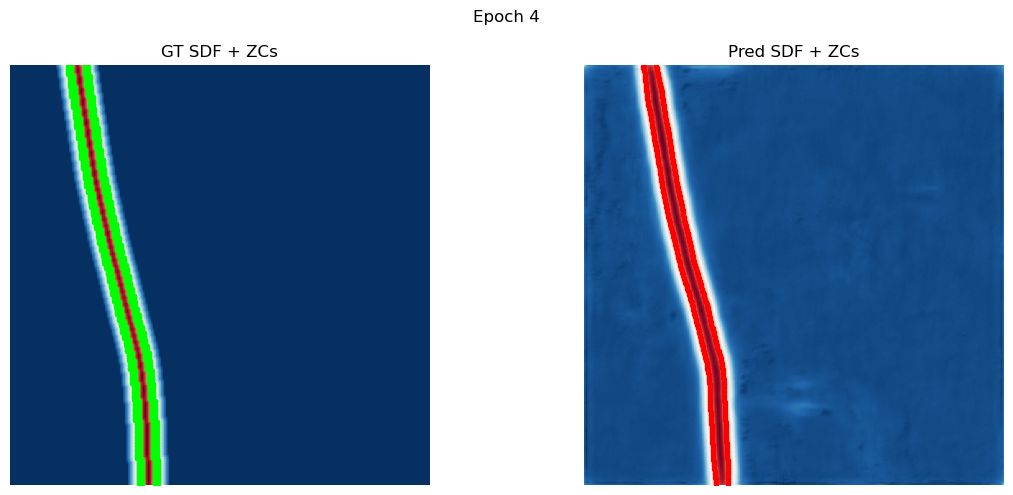

[Epoch 005/100]  Loss: 1.3536


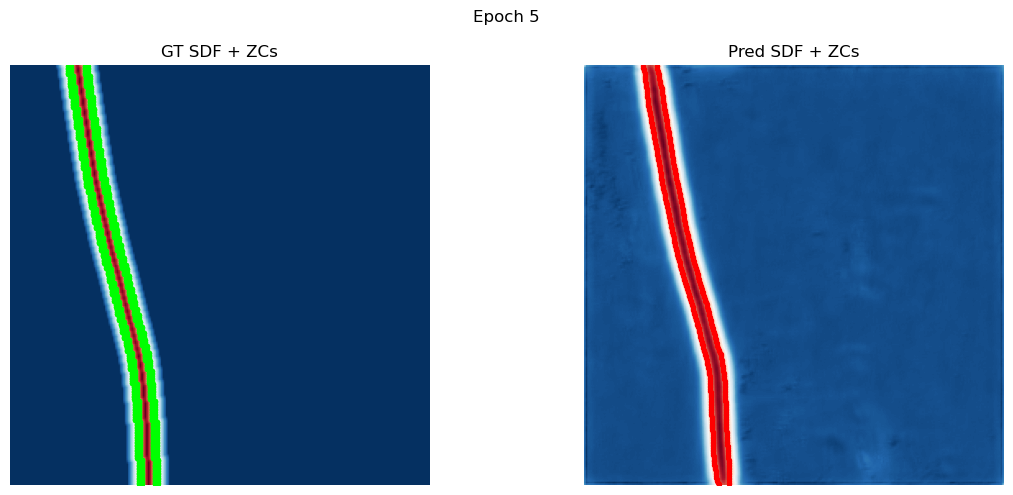

[Epoch 006/100]  Loss: 1.1962


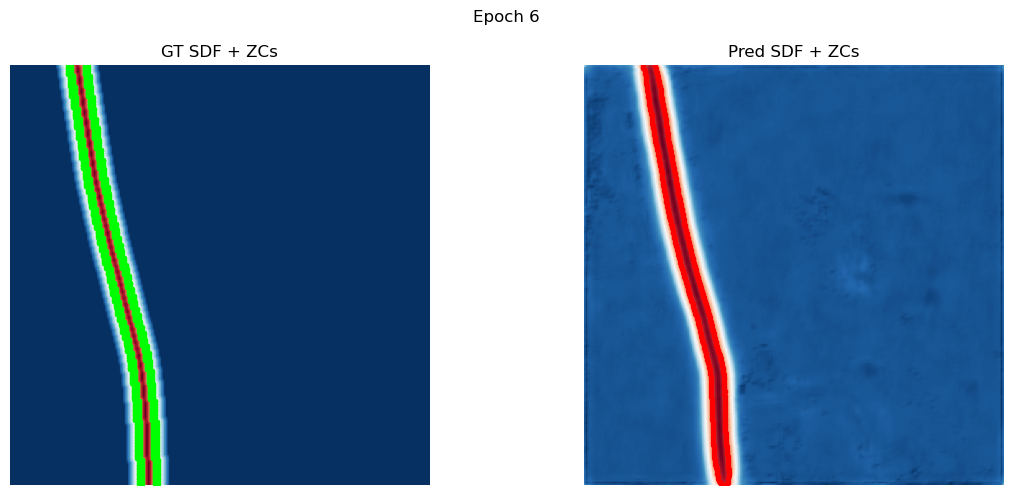

KeyboardInterrupt: 

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ─── Hyper‑parameters ────────────────────────────────────────────
NUM_EPOCHS     = 100
LR             = 1e-4
λ_sdf          = 1.0
λ_chamfer      = 1.0
dist_threshold = 3

# ─── Model, optimizer, loss ──────────────────────────────────────
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

from losses.chamfer_loss import (
    SDFChamferLoss,
    extract_zero_crossings_interpolated_positions
)
loss_fn = SDFChamferLoss(
    weight_sdf=1.0,
    weight_chamfer=1.0,
)

# loss_fn = SDFChamferLoss(
#     weight_sdf      = 1.0,
#     weight_chamfer  = 1.0,
#     update_scale    = 0.0,   # disables manual grad → matches second notebook
#     dist_threshold  = 1.5
# ).to(device)

# ─── Training loop ───────────────────────────────────────────────
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0

    for batch in smoke_dl:
        x = center_crop(batch["image_patch"], CROP_H, CROP_W).to(device)
        y = center_crop(batch["sdf_patch"],   CROP_H, CROP_W).to(device)

        pred = model(x)       # [B,1,H,W]
        gt   = y               # [B,1,H,W]

        # forward + loss
        loss = loss_fn(pred, gt)

        # backward + step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(smoke_dl)
    print(f"[Epoch {epoch:03d}/{NUM_EPOCHS:03d}]  Loss: {avg_loss:.4f}")

    # ─── Visualization ───────────────────────────────────────────
    model.eval()
    with torch.no_grad():
        sample_img  = x[0].cpu().permute(1,2,0).numpy()
        sample_gt   = gt[0,0].cpu().numpy()
        sample_pred = pred[0,0].cpu().numpy()

        # re‑extract zero crossings
        p_zc = extract_zero_crossings_interpolated_positions(
                    torch.from_numpy(sample_pred).to(device)
               ).cpu().numpy()
        g_zc = extract_zero_crossings_interpolated_positions(
                    torch.from_numpy(sample_gt).to(device)
               ).cpu().numpy()

        fig, axes = plt.subplots(1,2, figsize=(12,5))
        axes[0].imshow(sample_gt, cmap='RdBu')
        axes[0].scatter(g_zc[:,1], g_zc[:,0], c='lime', s=8)
        axes[0].set_title("GT SDF + ZCs")
        axes[0].axis('off')

        axes[1].imshow(sample_pred, cmap='RdBu')
        axes[1].scatter(p_zc[:,1], p_zc[:,0], c='red', s=8)
        axes[1].set_title("Pred SDF + ZCs")
        axes[1].axis('off')

        plt.suptitle(f"Epoch {epoch}")
        plt.tight_layout()
        plt.show()
